# 事前準備

所定のデータをダウンロードしてそれぞれ"data"ディレクトリに格納してください。
- sp500.csv: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
- nasdaq100.csv https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- nasdaq.csv: https://finance.yahoo.com/quote/%5ENDX/history?p=%5ENDX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import namedtuple

# データ読み込み及び前処理

In [2]:
file_names = ['sp500', 'nasdaq100']
datas = {k: pd.read_csv(f'data/{k}.csv') for k in file_names}

In [3]:
#前日比のカラムを作る
for key in datas.keys():
    close = datas[key]['Adj Close']
    datas[key] = datas[key].drop(0)#一つ目のデータだけ前日比が取れないので捨てる
    diff_percent = close.diff().values[1:]/close.values[:-1]
    datas[key]['day_ratio'] = diff_percent

# レバレッジの価格算出に誤りがないか検証

In [4]:
spxl = pd.read_csv('data/SPXL.csv')
close = spxl['Adj Close']
spxl = spxl.drop(0)
spxl['day_ratio'] = close.diff().values[1:]/close.values[:-1]
spxl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_ratio
1,2008-11-06,4.150000,4.197500,3.552500,3.600000,2.888150,4332000,-0.152941
2,2008-11-07,3.707500,3.887500,3.611667,3.854167,3.092059,6978000,0.070602
3,2008-11-10,4.150000,4.161667,3.584167,3.704167,2.971719,5785200,-0.038919
4,2008-11-11,3.541667,3.687500,3.291667,3.459167,2.775165,11479200,-0.066142
5,2008-11-12,3.327500,3.327500,3.017500,3.074167,2.466293,13312800,-0.111299


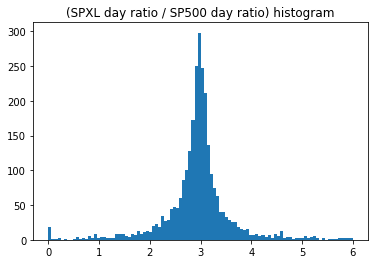

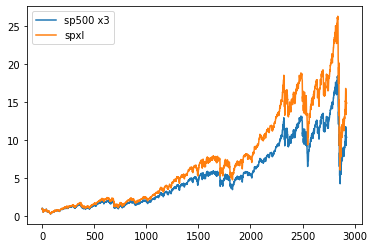

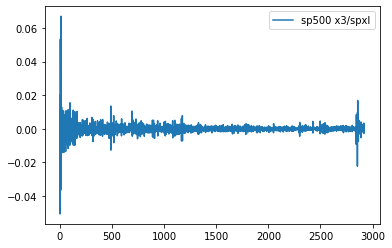

In [5]:
vs_spxl_sp500 = datas['sp500'].query('Date >= "2008-11-06"')
vs_spxl_sp500_plus1 = vs_spxl_sp500['day_ratio'].values+1
rr = spxl.day_ratio.values/(vs_spxl_sp500.day_ratio.values+ 1e-9)
plt.title('(SPXL day ratio / SP500 day ratio) histogram')
_ = plt.hist(rr, bins=100, range=(0,6))
plt.show()

n = 0
N = -1
sp500_ratio_3 = vs_spxl_sp500.day_ratio*3 + 1
cumprod_sp500_ratio_3 = np.cumprod(sp500_ratio_3.values)
t1 = (cumprod_sp500_ratio_3/cumprod_sp500_ratio_3[n])[n:N]
t2 = (spxl['Adj Close'].values/spxl['Adj Close'].iloc[n])[n:N]
plt.plot(t1, label='sp500 x3')
plt.plot(t2, label='spxl')
plt.legend()
plt.show()
plt.plot(np.diff(t1/t2), label='sp500 x3/spxl')
plt.legend()
plt.show()

乖離はあるがだいたい同じ挙動をしている.ただ一般に言う乖離は損な方向に働くものだとおもったけど買う側に有利な乖離だった

# もしリーマンショック以前にレバレッジETFがあったら

In [6]:
leverage = 3
for k in file_names:
    datas[k+'_x3'] = pd.DataFrame()
    ratio = datas[k].day_ratio*3
    #ratio.loc[ratio <= 0] = 1e-9
    datas[k+'_x3']['day_ratio'] = ratio 
    datas[k+'_x3']['Adj Close'] = np.cumprod(ratio+1)
    datas[k+'_x3']['Date'] = datas[k].Date

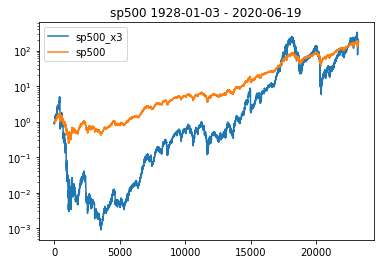

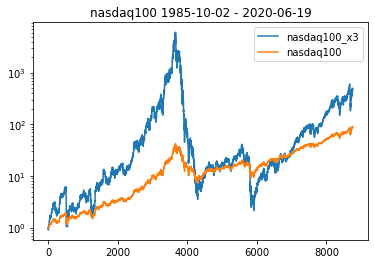

In [7]:
for k in file_names:
    x = datas[k].Date
    plt.title(f"{k} {x.iloc[0]} - {x.iloc[-1]}")
    l = k+'_x3'
    plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    l = k
    plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [8]:
results = {k:{} for k in datas.keys()}

# 買ったETF N年後どうなってる？

In [9]:
def exe1(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values.iloc[start+day_num-1]/values.iloc[start])
    return res

In [33]:
default_years=[1,2,3,4,5,10,20,30]
index_names = ['sp500', 'sp500_x3', 'nasdaq100', 'nasdaq100_x3']

In [11]:
def make_data(exe, name, years=default_years, **kwargs):
    for k in datas.keys():
        results[k][name] = {}
        for n in years:
            results[k][name][n] = exe(datas[k]['Adj Close'], day_num=n*240, **kwargs)

In [12]:
make_data(exe1, 'exe1', iteration=10000)

In [13]:
def show_hist(name, iteration=10000, years=default_years, bins=40, ranges=[[0,4], [0,40], [0,100]], ):
    for n in years:
        for k in index_names:
            if k[-1] != '3':
                for r in ranges:
                    #num, bins, patches = plt.hist([results[k][name][n], results[k+'_x3'][name][n]], bins=bins, ) # histogram
                    num1, _bins, _ = plt.hist(results[k][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x1', range=r, bins=bins)
                    num2, _bins, _ = plt.hist(results[k+'_x3'][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x3', range=r, bins=bins)
                    plt.grid()
                    plt.legend()
                    plt.xlabel('benfit x')
                    plt.ylabel('times')
                    plt.title(f'histgram {k} {n}years')
                    plt.show()
                    for i,_n in enumerate([num1, num2]):
                        plt.plot(_bins[:-1], np.cumsum(_n)/iteration*100, )
                    plt.legend([k+'_x1', k+'_x3'], loc='best')
                    plt.xlabel('benfit x')
                    plt.ylabel('%')
                    plt.grid()
                    plt.show()

In [ ]:
def show_mmm(name, years=default_years, ):
     for n in years:
        for k in index_names:   
            print(f'{n:02d}年 {k:13}: mean={np.mean(results[k][name][n]):5.2f} min={np.min(results[k][name][n]):5.2f} max={np.max(results[k][name][n]):5.2f}')
            print('  '.join([f'{_n:2d}%:{np.percentile(results[k][name][n], _n):5.2f}' for _n in [1,5,25, 50, 75, 95,99]])) 
            
show_mmm('exe1')

In [47]:
def make_df(name, ):
    percentile = [1,5,10,15,20,25, 50, 75, 95,99]
    res = []
    indexes = []
    for n in default_years:
        for k in index_names:
            indexes.append(f'{k}_{n}')
            tmp = []
            for i in percentile:
                tmp.append(np.percentile(results[k][name][n], i)) 
            res.append(tmp)
    res = pd.DataFrame(res, index=indexes, columns=[f'{i}%' for i in percentile])
    return res

make_df('exe1')

,1%,5%,10%,15%,20%,25%,50%,75%,95%,99%
sp500_1,0.551713,0.746205,0.830736,0.876581,0.920031,0.957913,1.084299,1.191107,1.357176,1.494311
sp500_x3_1,0.119869,0.314590,0.499406,0.600112,0.710415,0.823390,1.206248,1.579360,2.311922,3.006880
nasdaq100_1,0.433446,0.647611,0.835695,0.960132,1.004127,1.030732,1.155725,1.280601,1.616792,1.844438
nasdaq100_x3_1,0.030299,0.157605,0.435552,0.744210,0.910490,0.988146,1.380651,1.909443,3.312616,4.591461
sp500_2,0.414137,0.676966,0.792983,0.875960,0.944236,1.003379,1.150654,1.303027,1.572263,1.808668
sp500_x3_2,0.019400,0.181805,0.351892,0.520670,0.674207,0.834527,1.346712,1.984603,3.454245,4.706491
nasdaq100_2,0.285240,0.617547,0.826215,1.018979,1.089778,1.136761,1.285373,1.509807,2.088076,3.163991
nasdaq100_x3_2,0.005839,0.061794,0.246461,0.605045,0.914254,1.146737,1.709161,2.934541,6.169439,16.244052
sp500_3,0.323019,0.667389,0.757489,0.852256,0.952040,1.023400,1.232389,1.411822,1.832692,2.055146
sp500_x3_3,0.008205,0.154283,0.251423,0.393627,0.594939,0.817087,1.546608,2.345075,4.728722,6.944802


In [30]:
def show_hakohige(name, years=default_years, ):
    for kk in file_names:
        for k in [kk, kk+'_x3']: 
            labels = []
            # 箱ひげ図
            fig, ax = plt.subplots()
            plt.title(f'{k}')
            # ラベル名
            plt.xlabel('year')
            plt.ylabel('benefit x')
            # Y軸のメモリの長さ
            plt.grid()
            points = []
            for n in years:
                labels.append(n)
                points.append(results[k][name][n])
            plt.yscale('log')
            ax.boxplot(points, showfliers=False)
            ax.set_xticklabels(labels)
            plt.show()

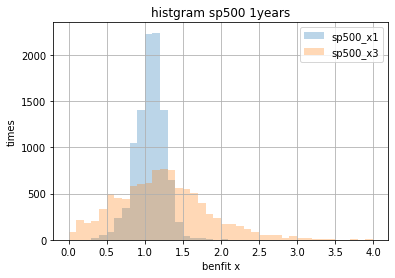

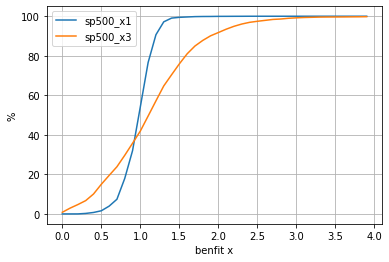

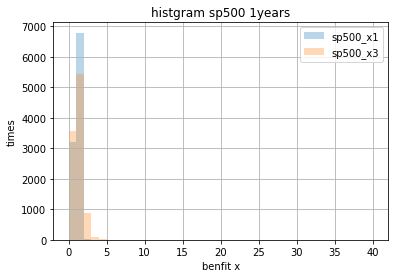

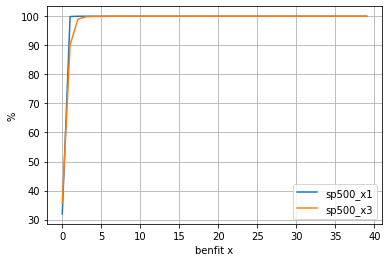

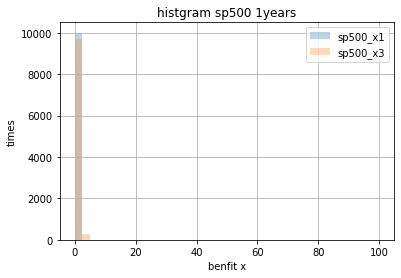

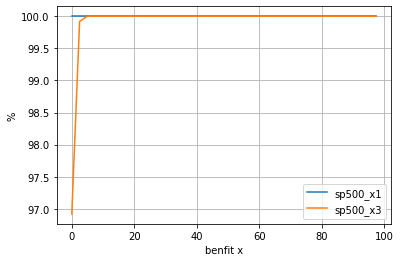

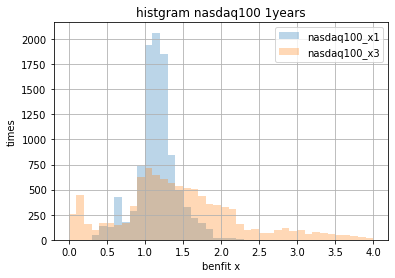

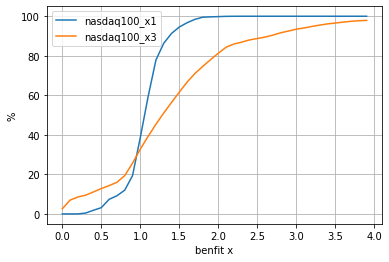

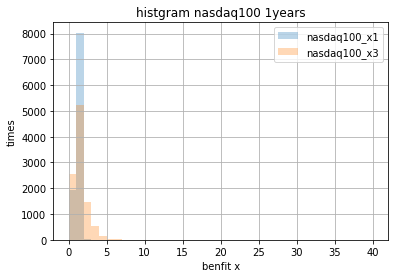

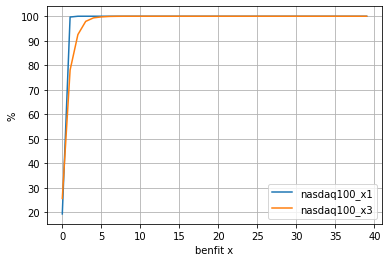

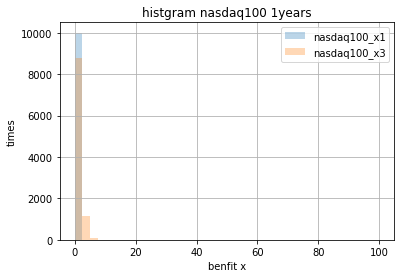

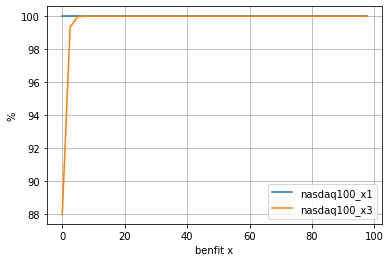

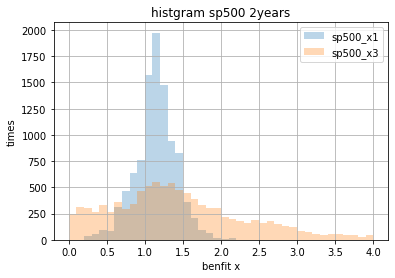

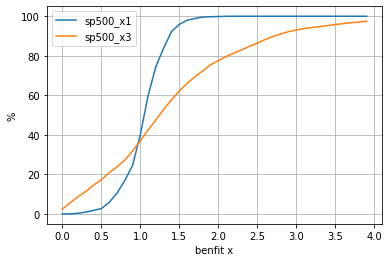

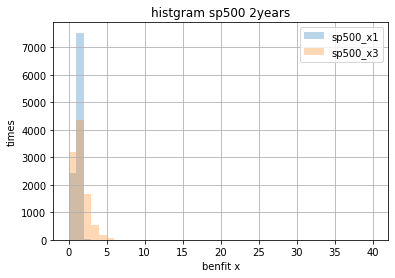

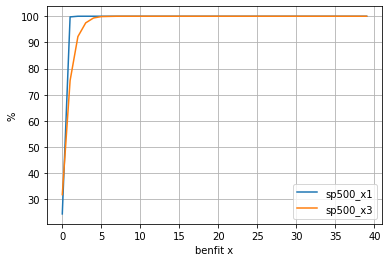

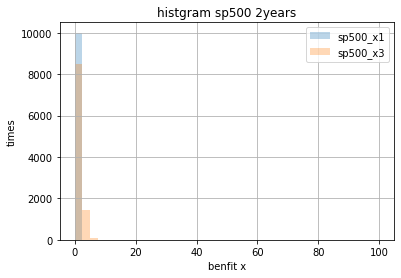

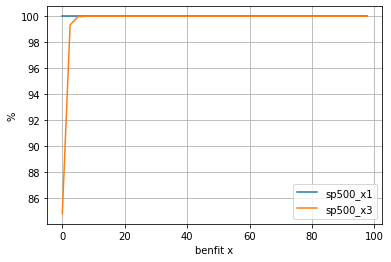

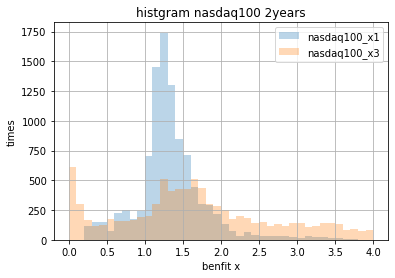

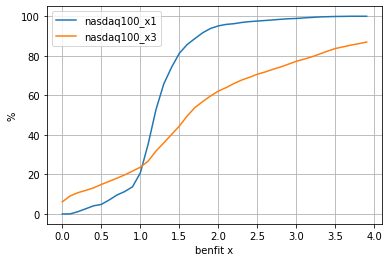

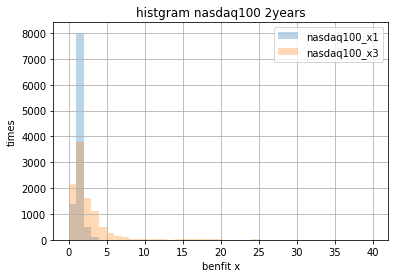

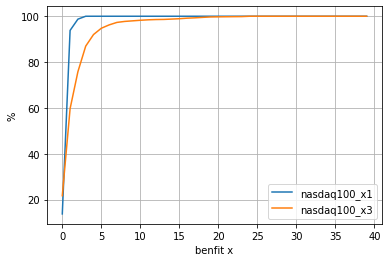

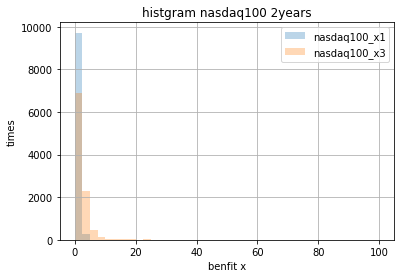

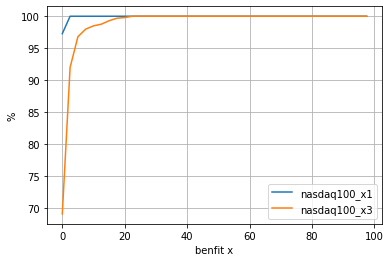

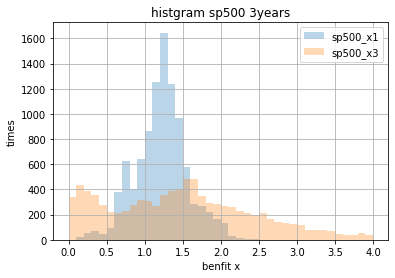

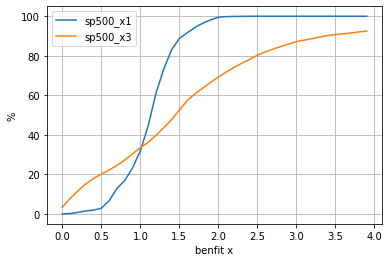

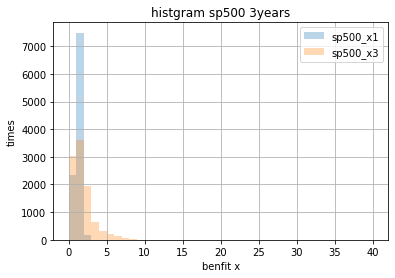

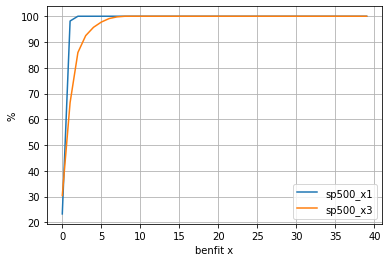

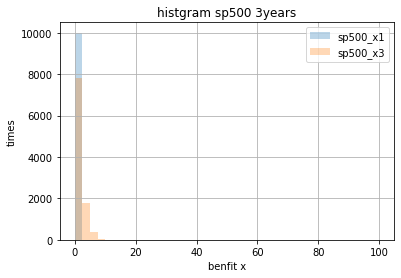

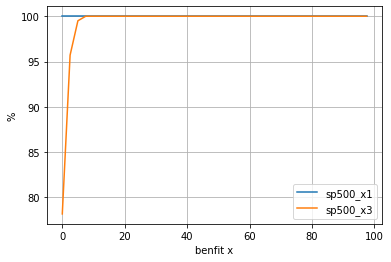

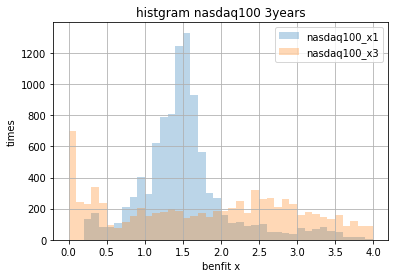

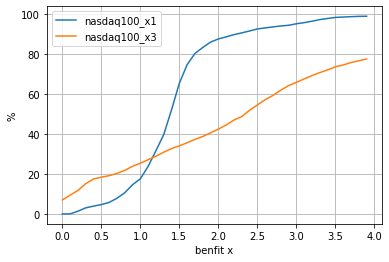

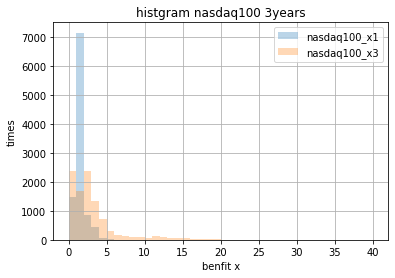

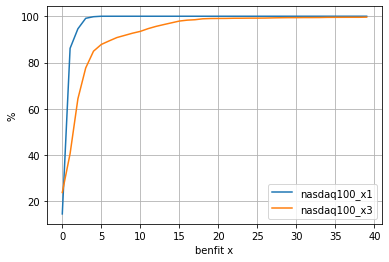

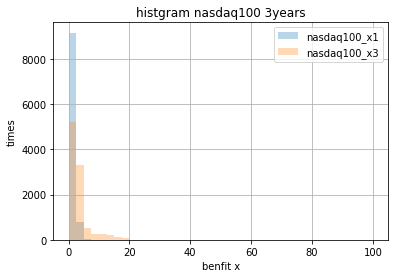

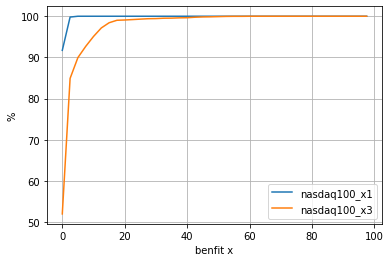

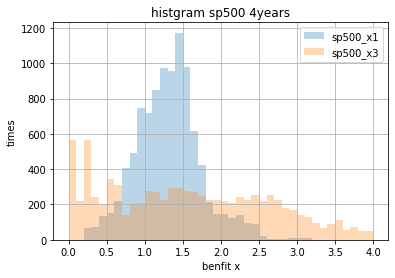

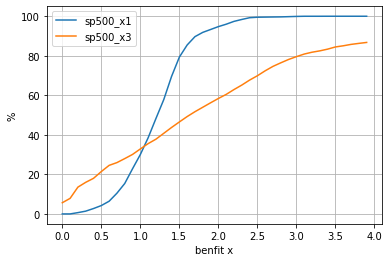

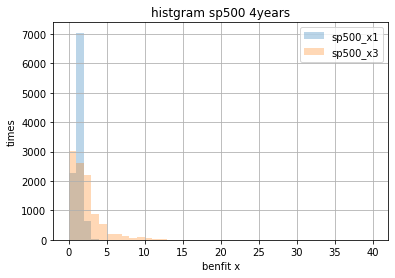

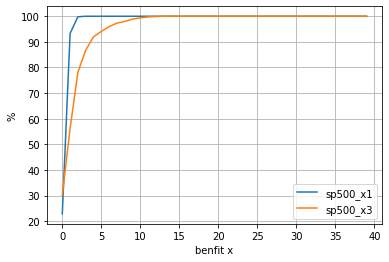

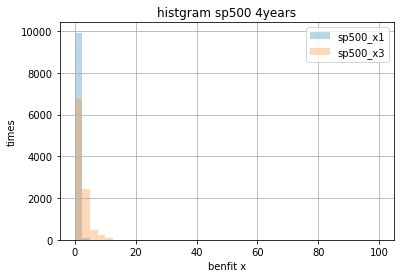

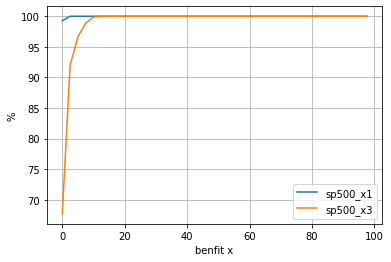

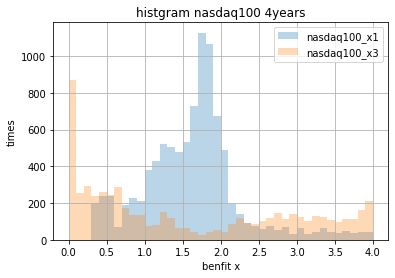

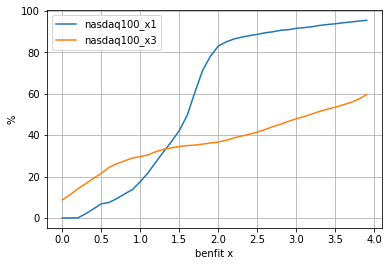

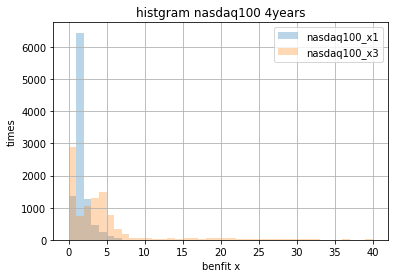

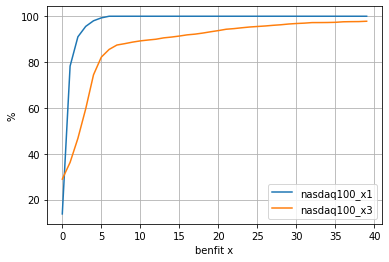

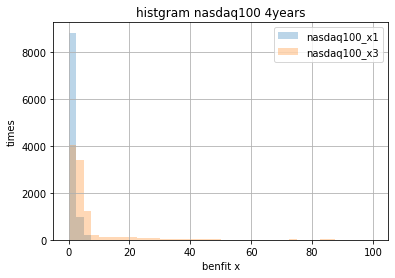

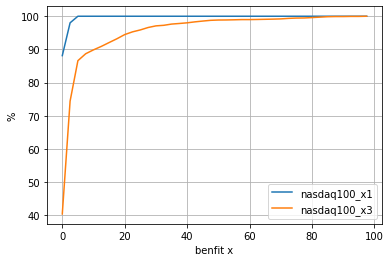

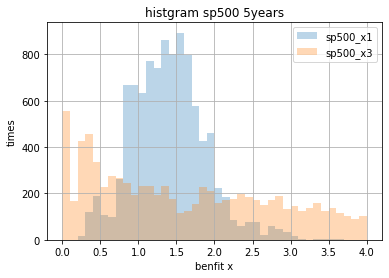

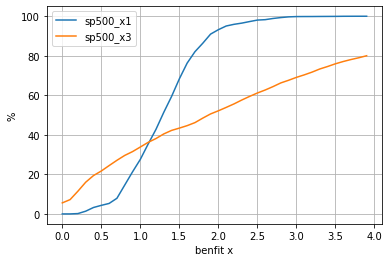

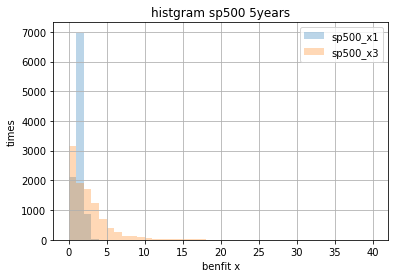

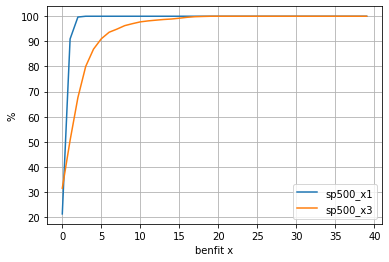

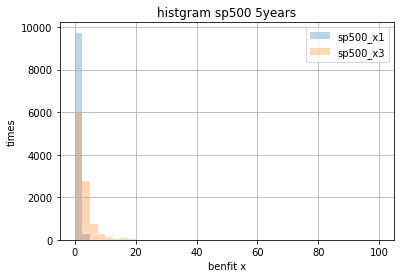

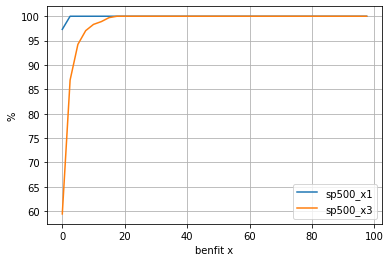

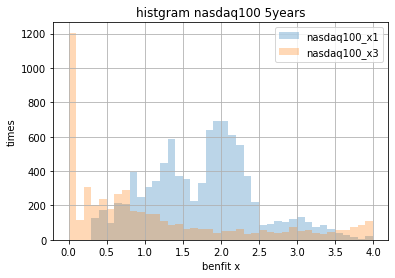

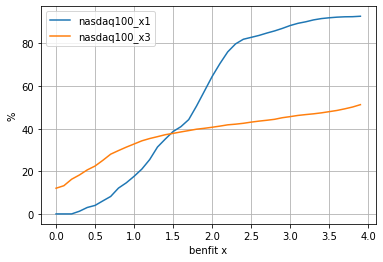

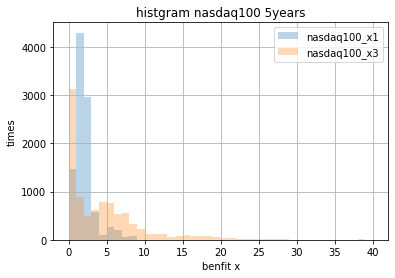

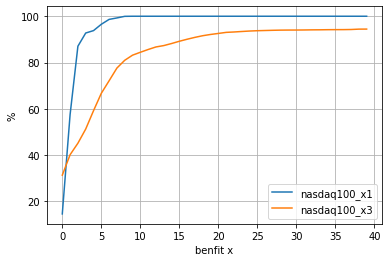

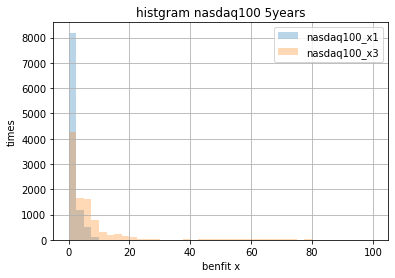

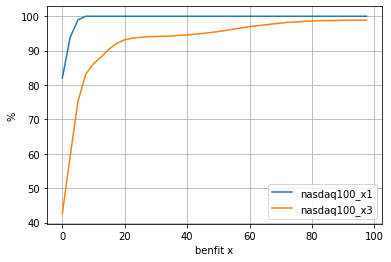

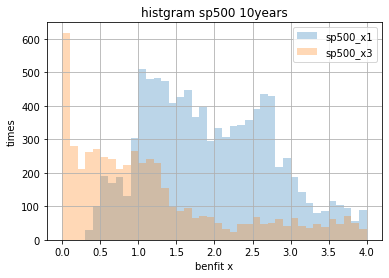

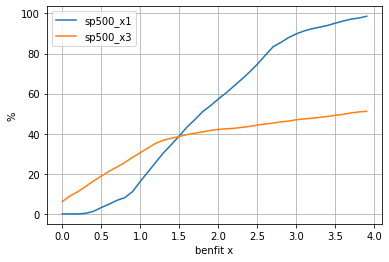

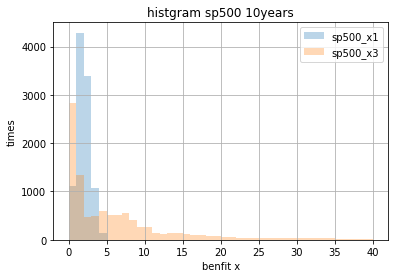

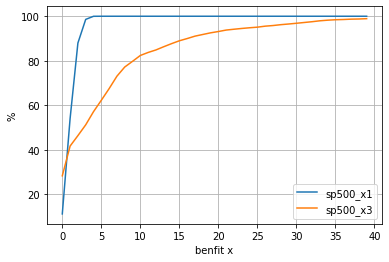

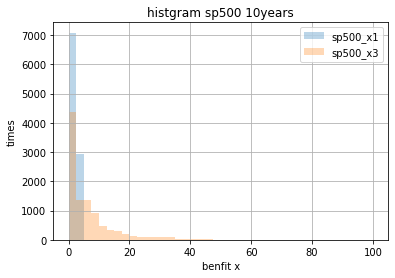

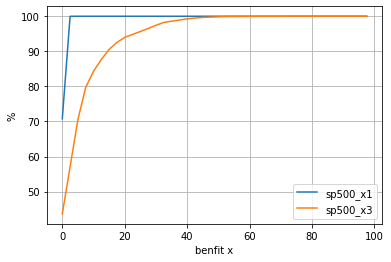

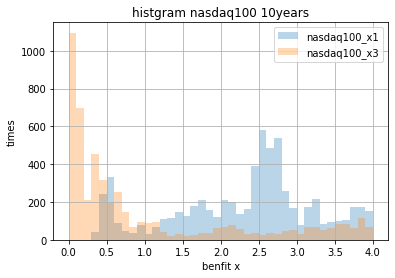

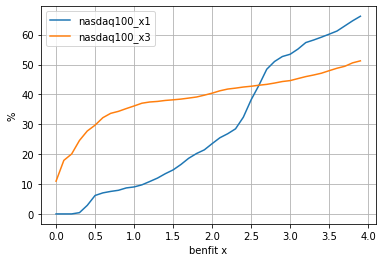

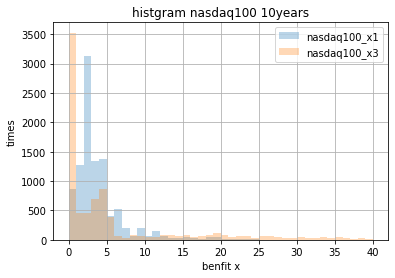

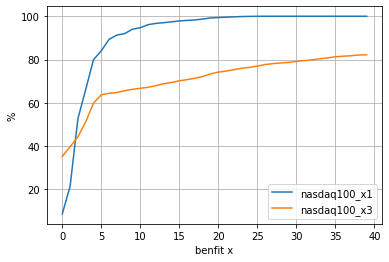

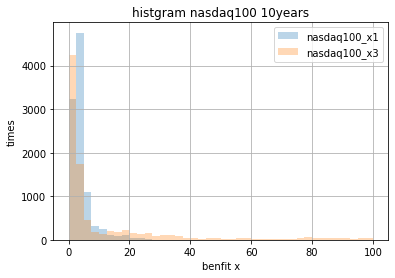

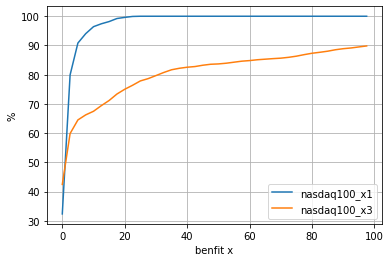

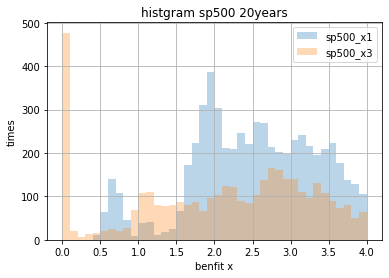

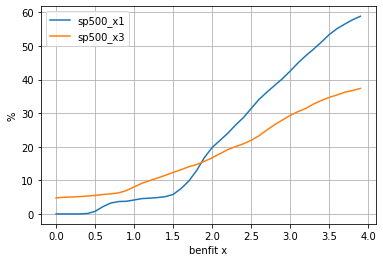

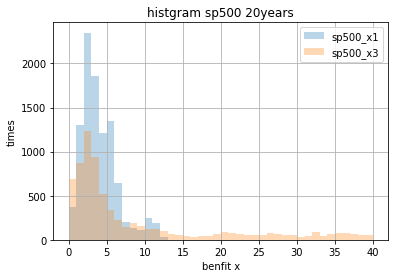

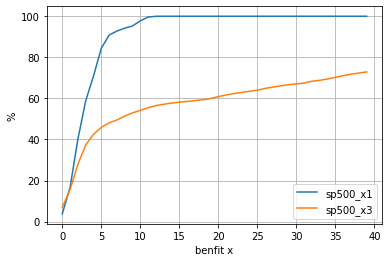

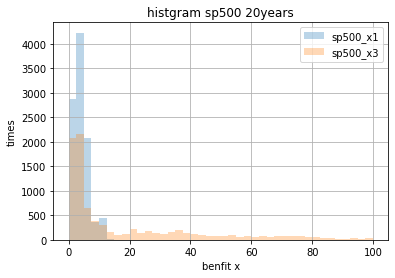

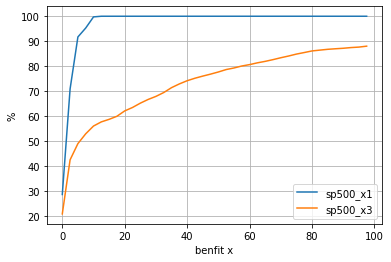

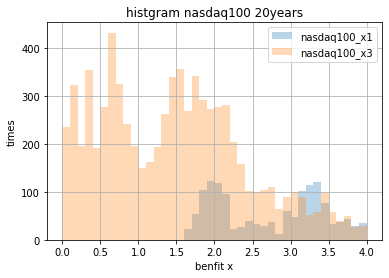

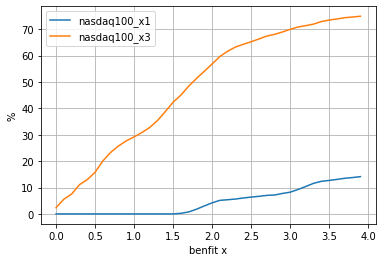

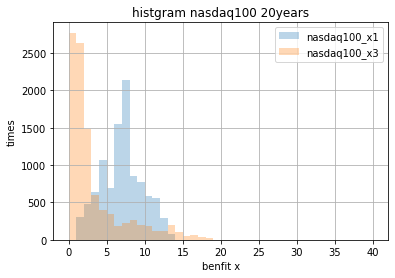

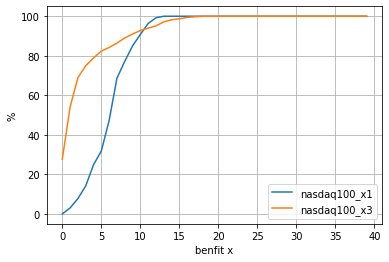

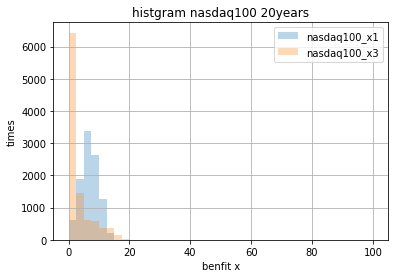

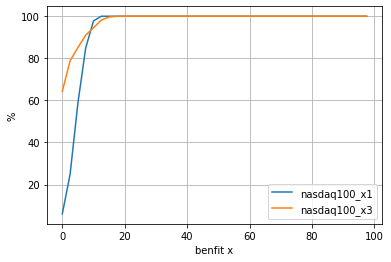

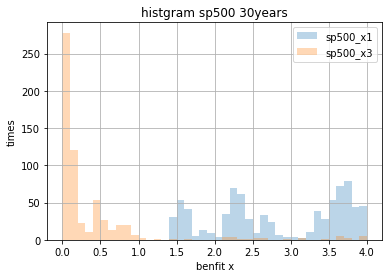

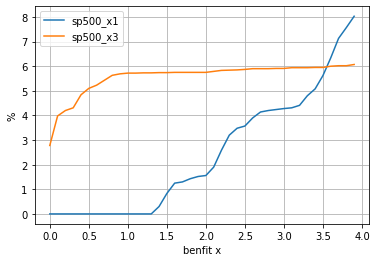

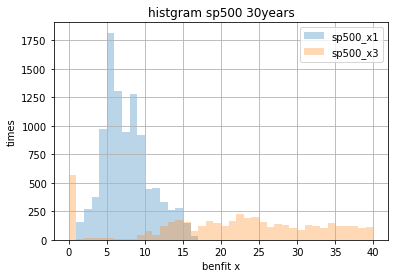

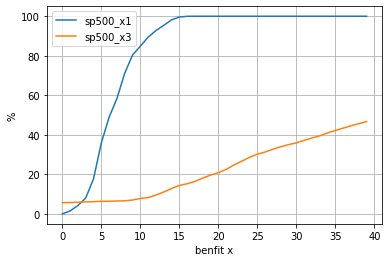

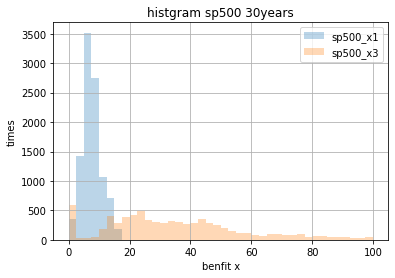

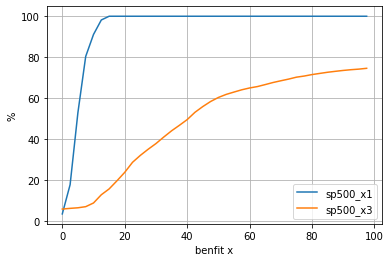

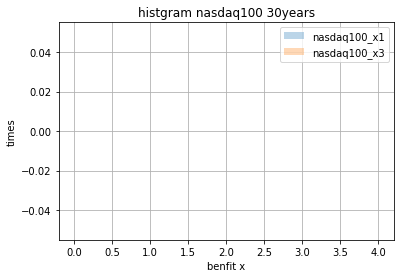

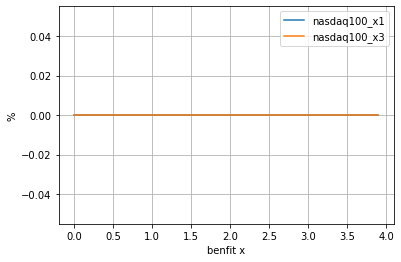

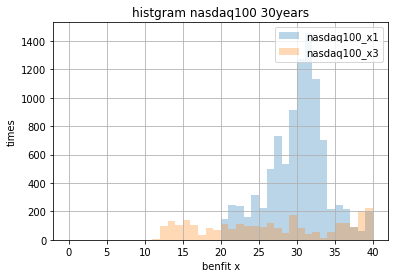

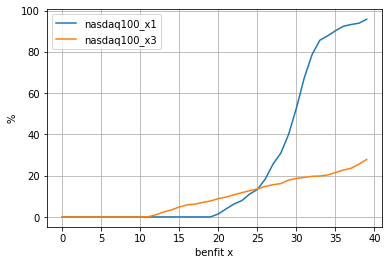

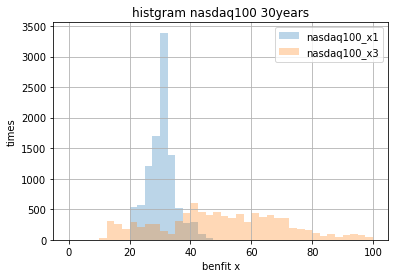

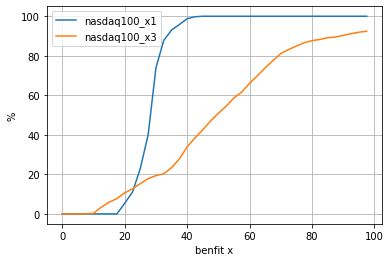

In [26]:
show_hist('exe1')

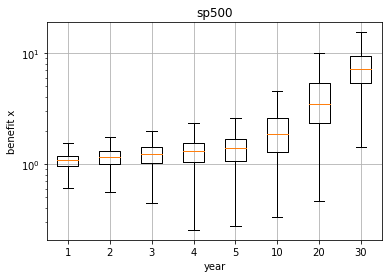

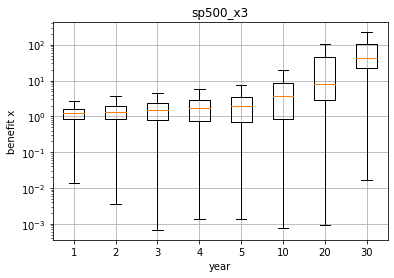

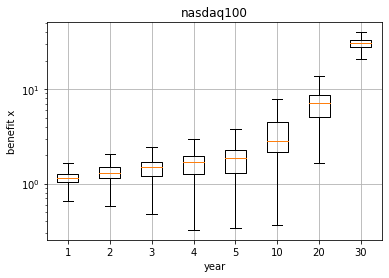

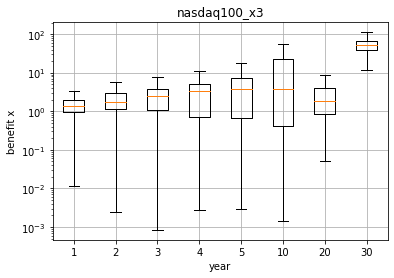

In [31]:
show_hakohige('exe1')

# N年間積立投資をした場合

In [18]:
def exe2(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values[start+day_num-1]*np.mean(1/values[start:start+day_num].values))
    return res

In [19]:
make_data(exe2, 'exe2', iteration=10000)

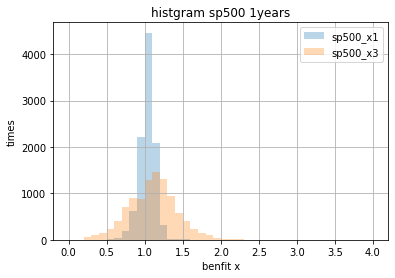

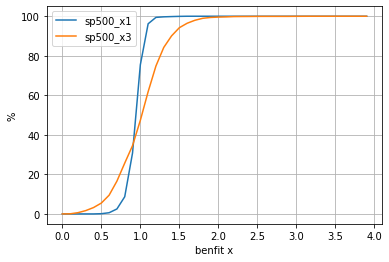

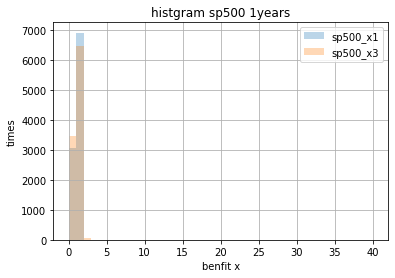

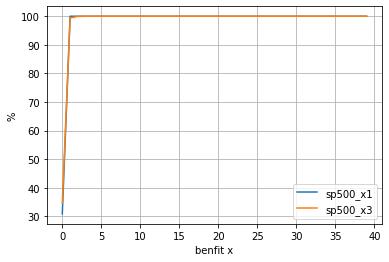

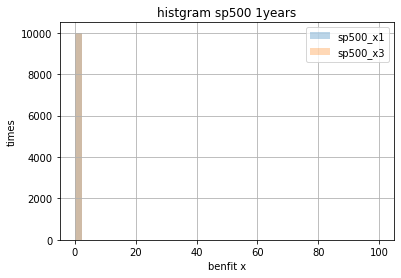

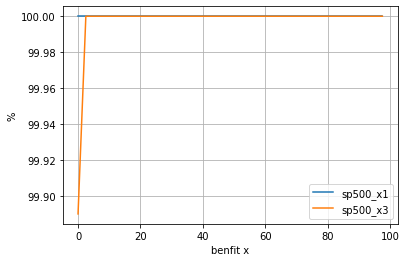

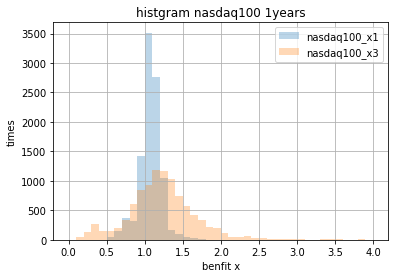

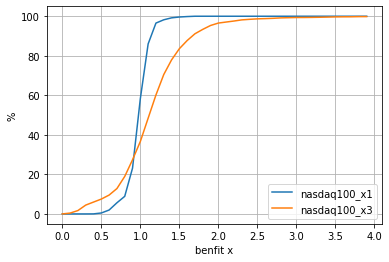

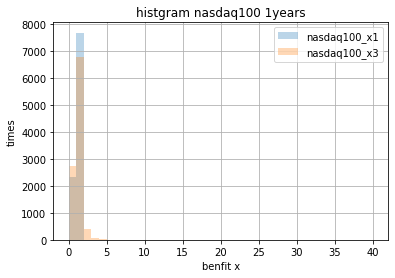

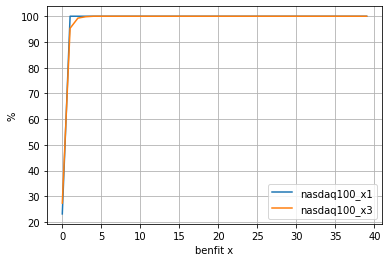

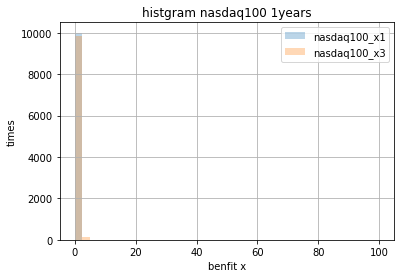

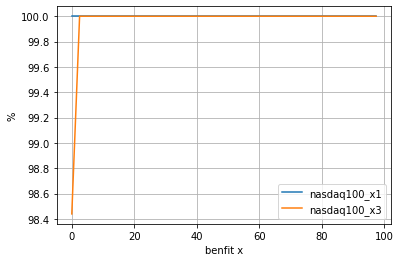

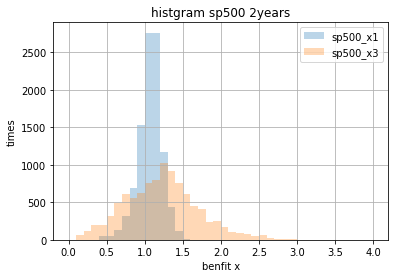

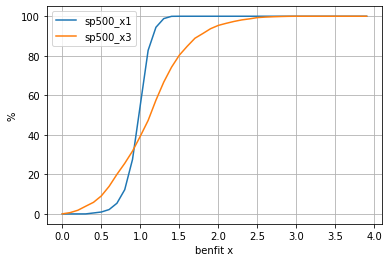

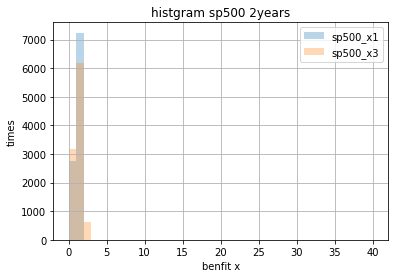

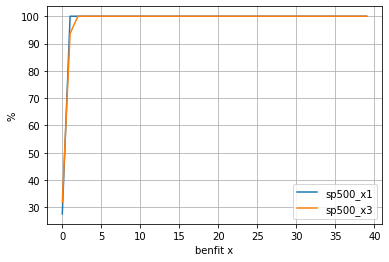

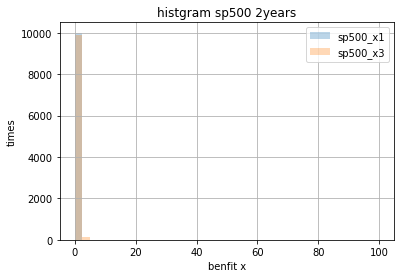

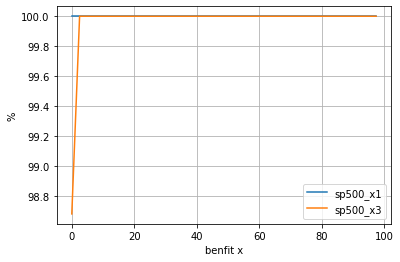

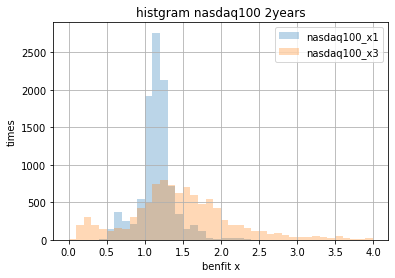

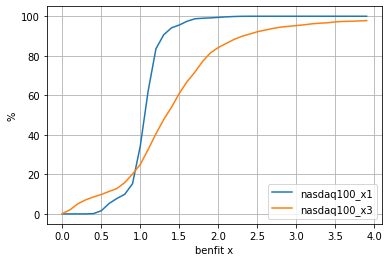

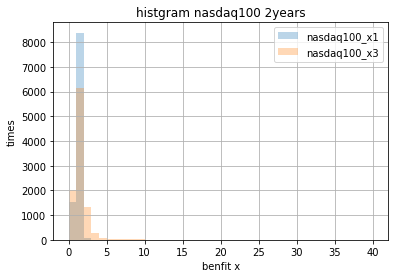

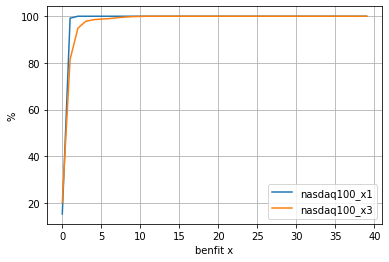

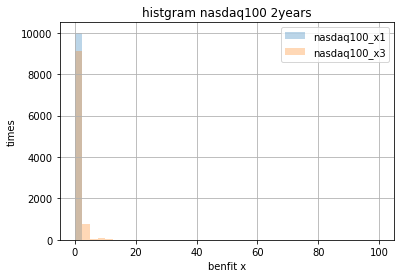

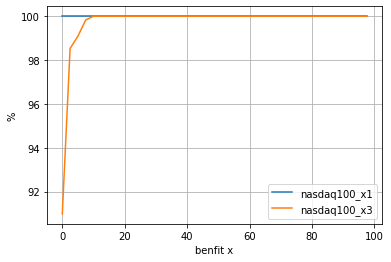

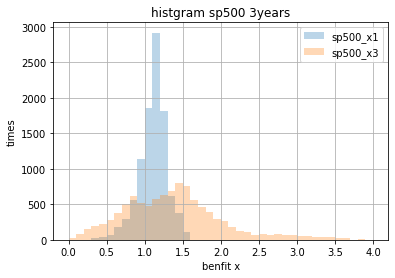

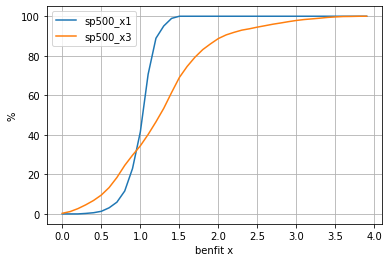

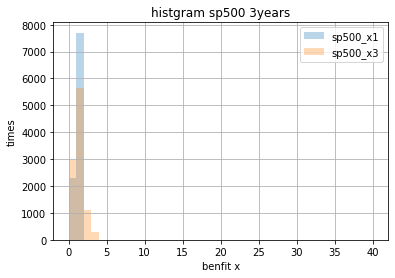

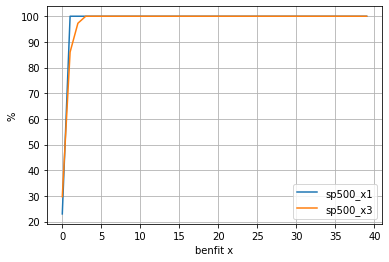

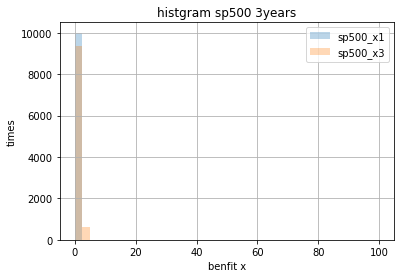

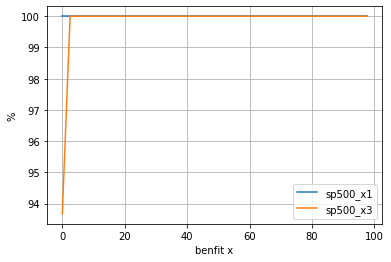

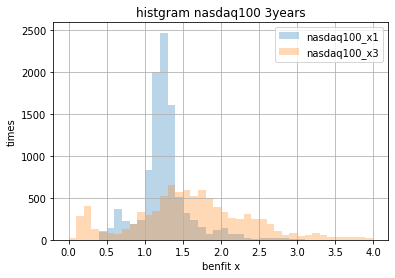

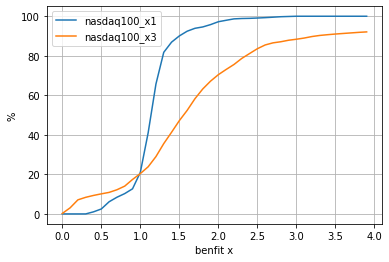

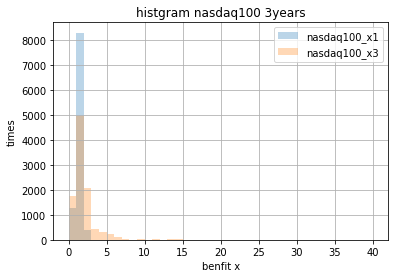

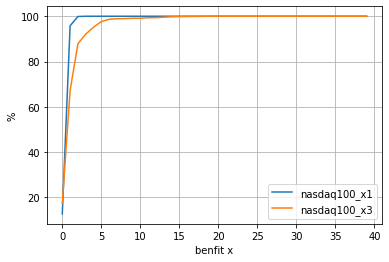

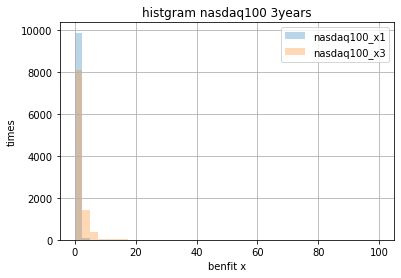

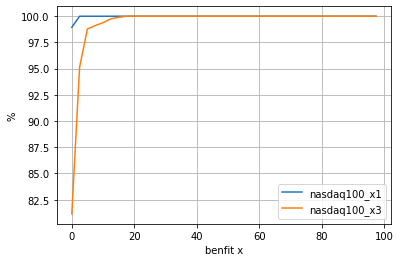

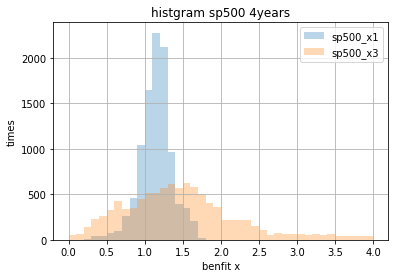

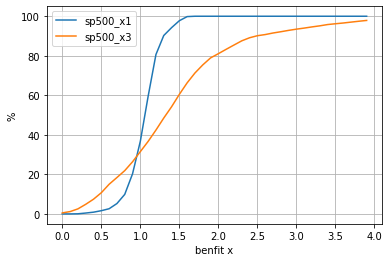

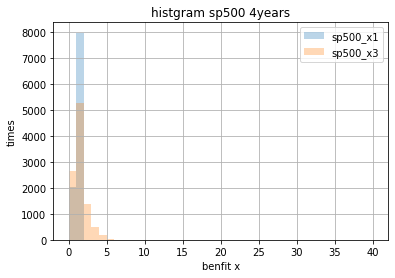

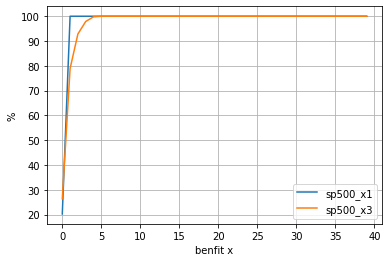

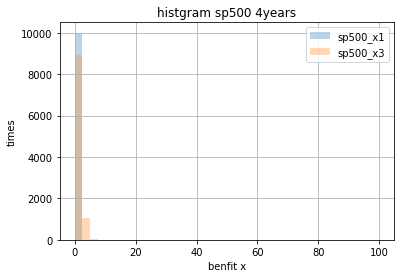

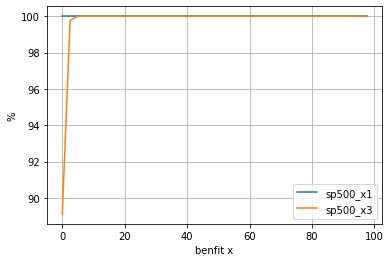

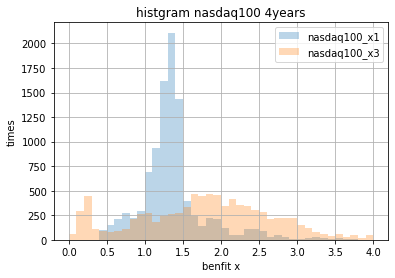

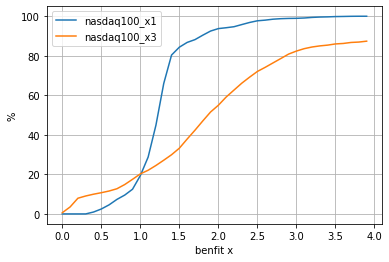

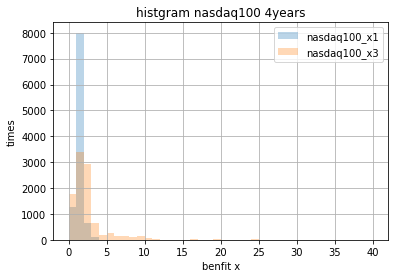

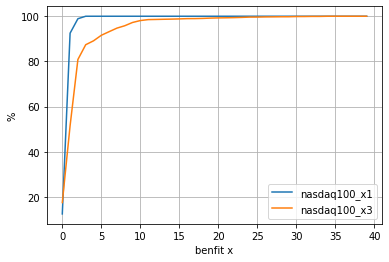

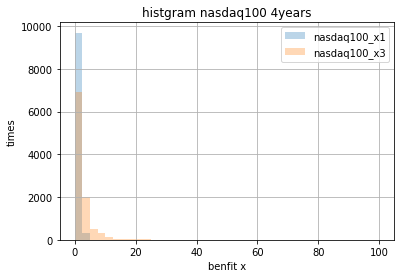

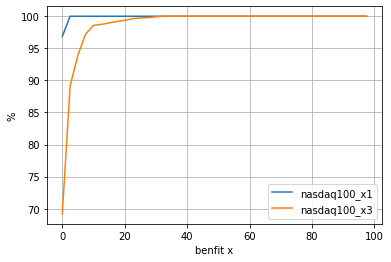

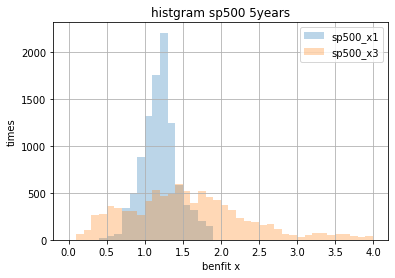

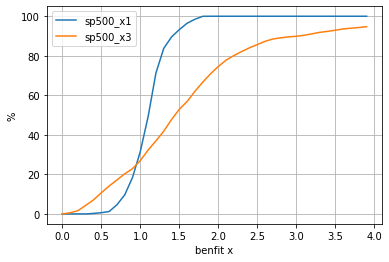

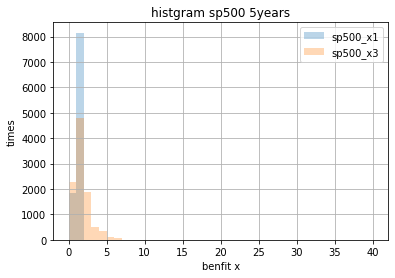

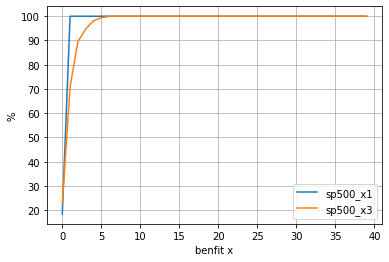

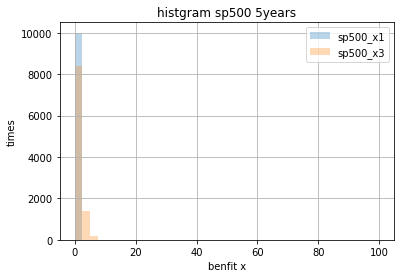

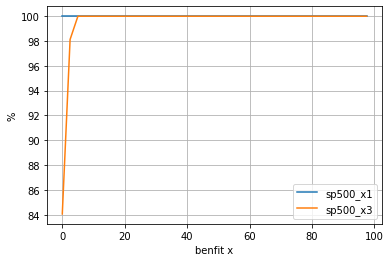

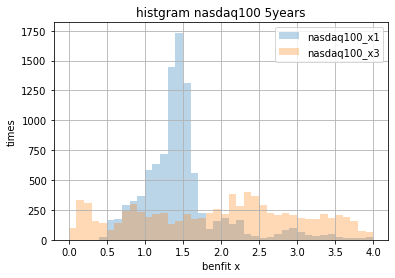

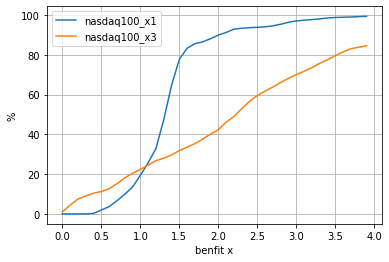

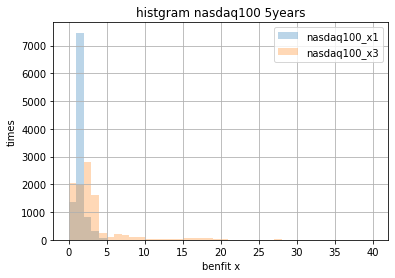

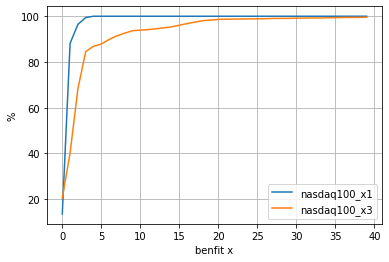

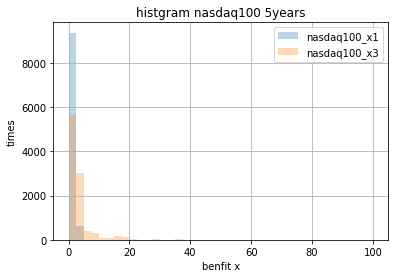

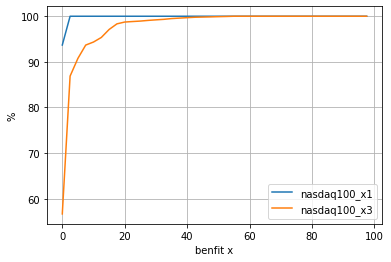

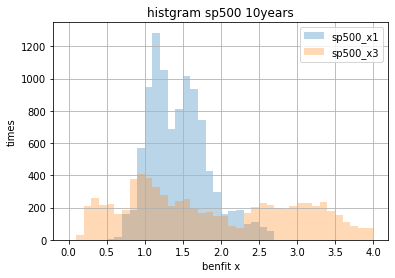

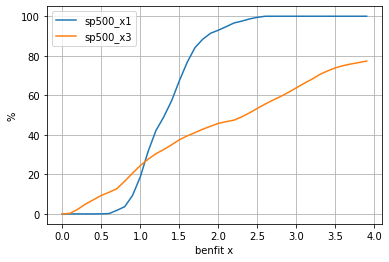

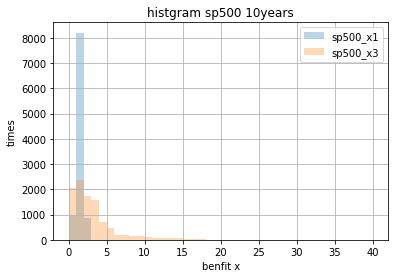

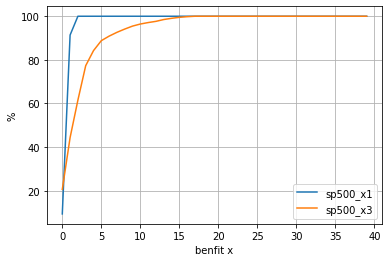

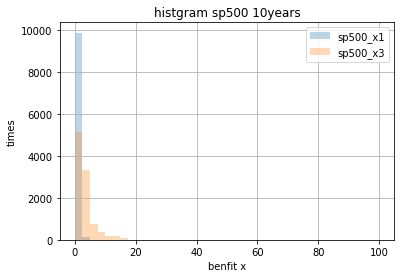

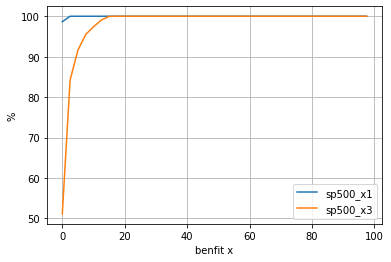

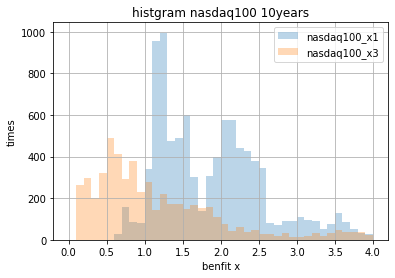

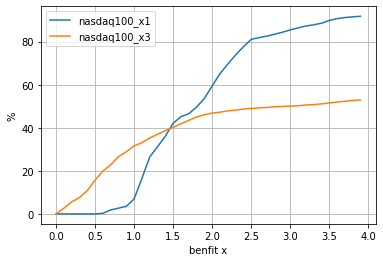

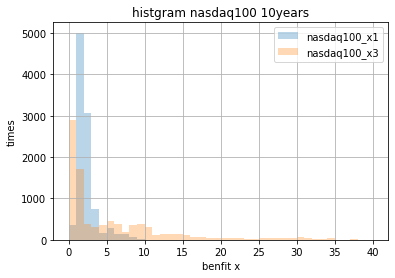

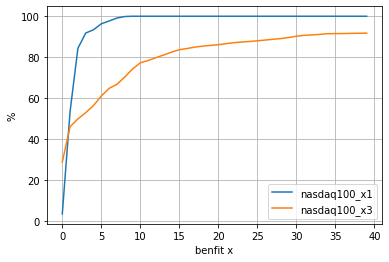

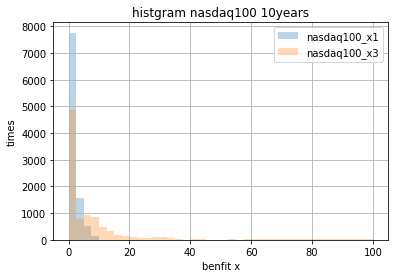

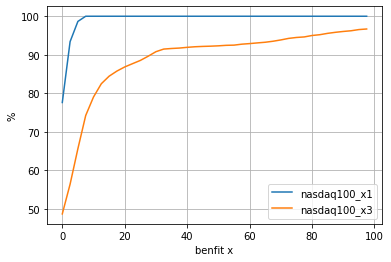

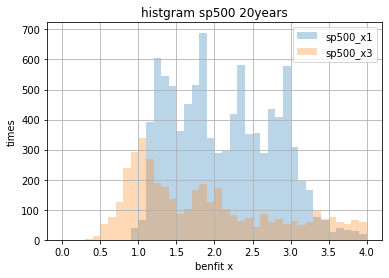

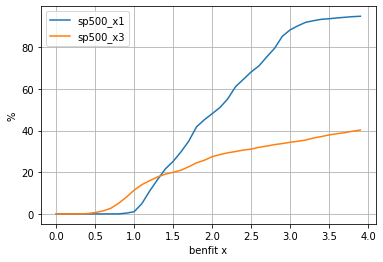

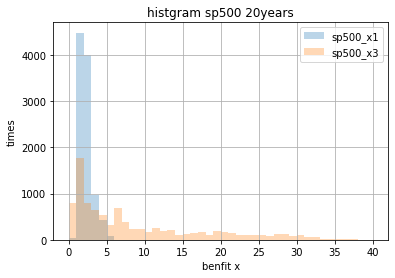

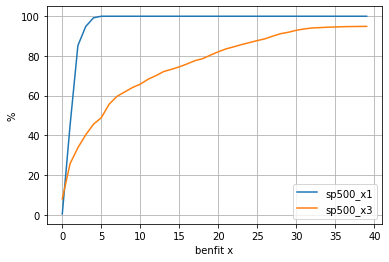

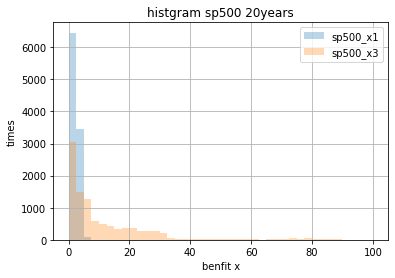

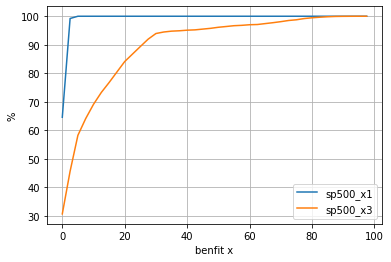

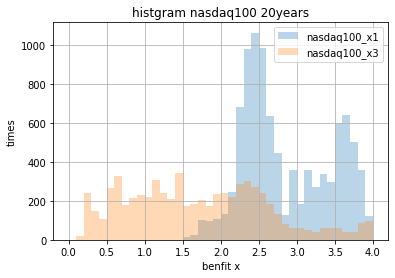

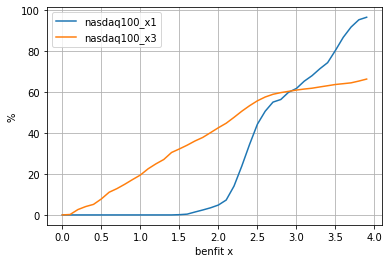

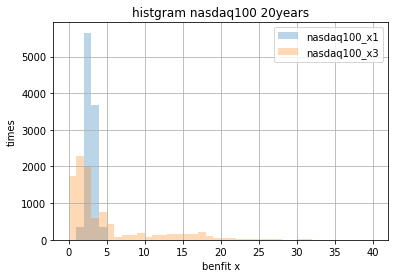

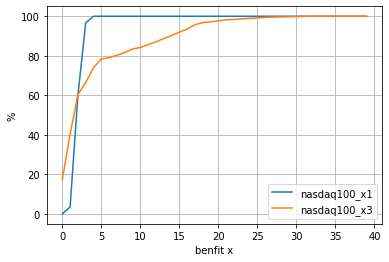

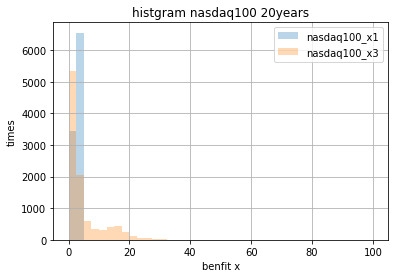

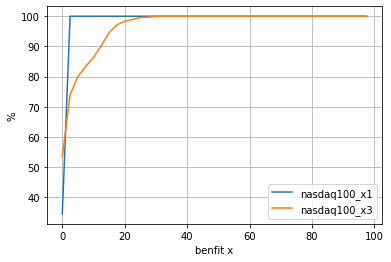

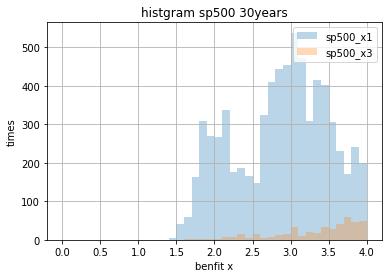

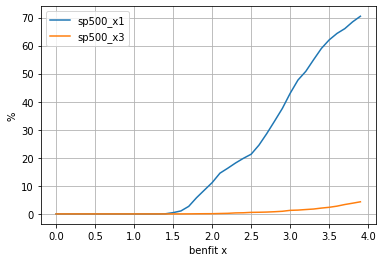

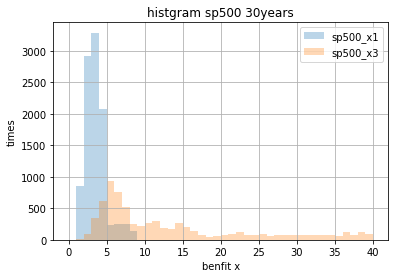

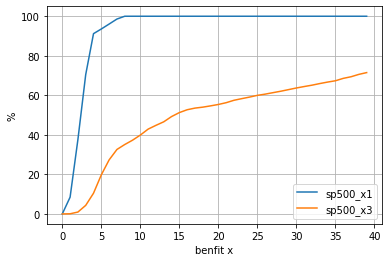

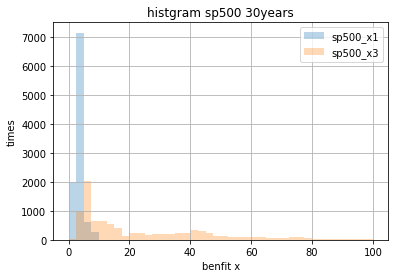

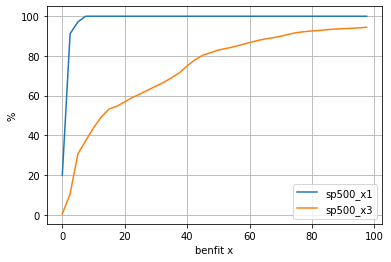

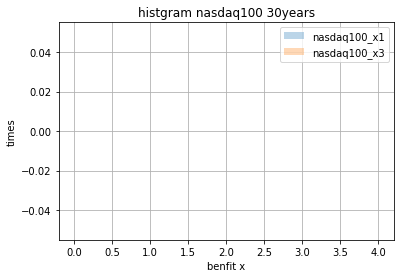

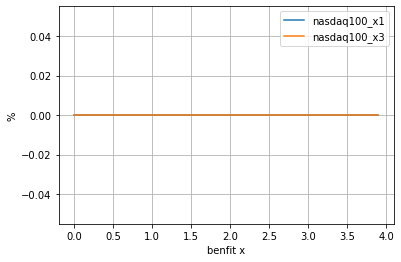

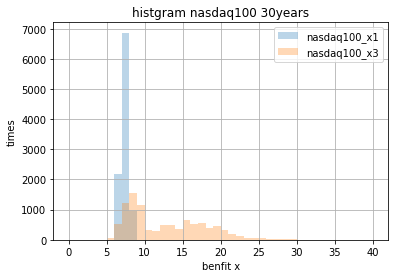

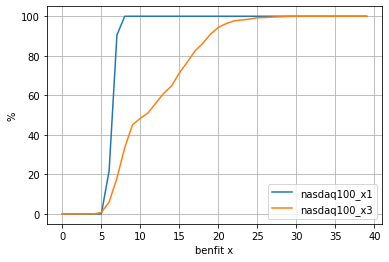

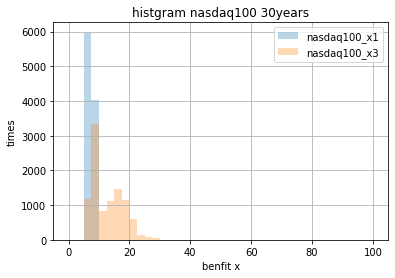

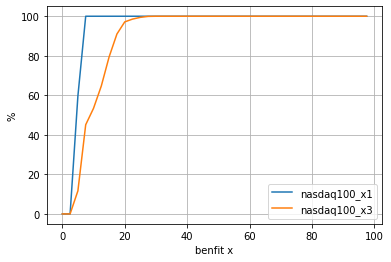

In [20]:
show_hist('exe2')

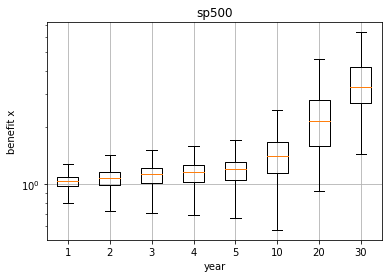

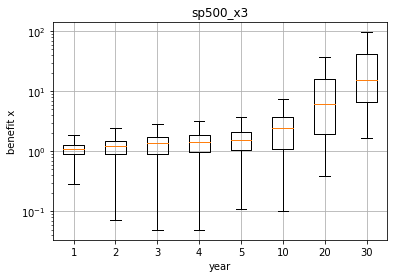

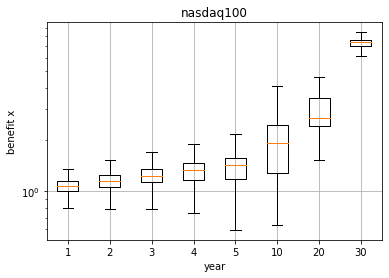

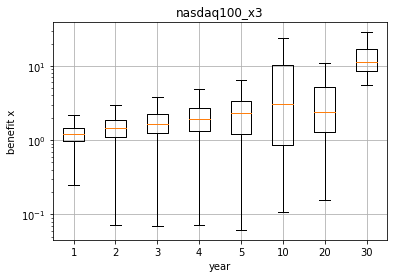

In [32]:
show_hakohige('exe2')

In [ ]:
df2 = make_df('exe2')

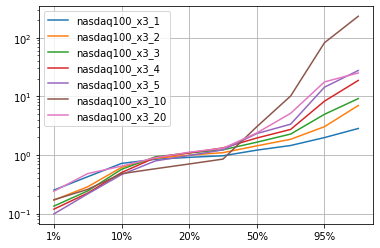

In [52]:
df2.iloc[3:-1:4].T.plot()
plt.yscale('log')
plt.grid()

# 死亡(10%以下)、危篤(10-50)、重症(50-80)、軽症(80-90)、小康（90-100）、ハッピー(100-200）、ウルトラハッピー（200-1000）、テンバガー（1000-）

In [23]:
score_dict = {'<=0.1': lambda x: x<0.1, '<=0.5': lambda x: 0.1<=x<0.5, '<=0.8': lambda x: 0.5<x<=0.8, '<=0.9': lambda x:0.8<x<=0.9,
             '  <=1': lambda x: 0.9<x<=1, '  <=2': lambda x:1<x<=2, '  <=5': lambda x: 2<x<=5, ' <=10': lambda x: 5<x<=10, '  >10':lambda x:10<x}

res = {}
for f in index_names:
    res[f] = {}
    for e in ['exe1', 'exe2']:
        res[f][e] = {}
        for n in default_years:
            res[f][e][n] = {k: 0 for k in score_dict.keys()}
            for s in results[f][e][n]:
                for k in score_dict.keys():
                    if score_dict[k](s):
                        res[f][e][n][k] += 1
                        break
            

In [24]:
for f in index_names:
    for e in ['exe1', 'exe2']:
        print('name\t\t\t '+' '.join([k for k in score_dict.keys()]))
        for n in default_years:
            print(f'{f} {e} {n:02d}\t'+('\t' if f=='sp500' else '') +''.join([' {0:5d}'.format(res[f][e][n][k]) for k in score_dict.keys()]))

name			 <=0.1 <=0.5 <=0.8 <=0.9   <=1   <=2   <=5  <=10   >10
sp500 exe1 01		     0    73   668  1052  1406  6791    10     0     0
sp500 exe1 02		     0   180   863   640   764  7528    25     0     0
sp500 exe1 03		     0   193  1094   400   641  7487   185     0     0
sp500 exe1 04		     0   272   776   490   752  7040   670     0     0
sp500 exe1 05		     0   325   466   669   669  6967   904     0     0
sp500 exe1 10		     0   130   547   132   305  4286  4598     2     0
sp500 exe1 20		     0    12   311    45     8  1297  5419  2436   472
sp500 exe1 30		     0     0     0     0     0   152  1623  6263  1962
name			 <=0.1 <=0.5 <=0.8 <=0.9   <=1   <=2   <=5  <=10   >10
sp500 exe2 01		     0     0   251   618  2212  6919     0     0     0
sp500 exe2 02		     0    48   491   687  1534  7240     0     0     0
sp500 exe2 03		     0    60   535   564  1140  7701     0     0     0
sp500 exe2 04		     0    88   437   462  1040  7973     0     0     0
sp500 exe2 05		     0    24   438   